
### Imports

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
import json
import matplotlib.pyplot as plt
import os
%matplotlib inline


### Let's see what's in the folder Spotify sends

In [4]:
spotify_data = "./spotify_data/"

files = os.listdir(spotify_data)

files

['.DS_Store',
 'StreamingHistory2.json',
 'StreamingHistory3.json',
 'StreamingHistory0.json',
 'StreamingHistory1.json',
 '.ipynb_checkpoints',
 'madpeople.tsv']

### JSON reader function

In [5]:
def load_json(json_filename):
    with open(json_filename, encoding="utf8") as f:
        dict_from_json = json.loads(f.read())
    return dict_from_json

def json_to_df(json_filename):
    json_file = load_json(json_filename)
    return pd.DataFrame(json_file)

### Load streaming history as a single dataframe

In [6]:
# create a list of my streaming history files
streaming_history = [file for file in files if "StreamingHistory" in file]

streaming_history

['StreamingHistory2.json',
 'StreamingHistory3.json',
 'StreamingHistory0.json',
 'StreamingHistory1.json']

In [7]:
# load each file as dataframe and then concat
list_df = []

# loop through list of streaming_history files
# save each created dataframe in list
for item in streaming_history:
    item_dict = load_json(spotify_data + item)
    item_df = pd.DataFrame(item_dict)
    list_df.append(item_df)

# concat list plus some sorting and rearranging
df_history = (
    pd
    .concat(list_df)  
    .sort_values(by="endTime")
    .reset_index(drop=True)
)

df_history

,endTime,artistName,trackName,msPlayed
0,2018-12-29 13:29,Jeff Buckley,Everybody Here Wants You,195299
1,2018-12-29 13:33,Future Islands,Time On Her Side,218506
2,2018-12-29 13:35,The Whitest Boy Alive,Burning,144044
3,2018-12-29 13:36,The Whitest Boy Alive,Burning,47144
4,2018-12-29 13:41,Cut Copy,Take Me Over,248289
...,...,...,...,...
30161,2019-12-29 12:47,El Palacio de Linares,Ciervo y Erizo,149266
30162,2019-12-29 12:48,Los Chikos del Maiz,Grupo Salvaje,19772
30163,2019-12-29 13:00,Los Chikos del Maiz,Grupo Salvaje,169087
30164,2019-12-29 13:03,John Grant,GMF,181394


In [8]:
df_history.dtypes

endTime       object
artistName    object
trackName     object
msPlayed       int64
dtype: object

In [9]:
df_history.describe()

,msPlayed
count,3.016600e+04
mean,1.480600e+05
std,1.085951e+05
min,0.000000e+00
25%,5.009600e+04
50%,1.528260e+05
75%,2.198798e+05
max,1.812570e+06


In [10]:
df_history.shape

(30166, 4)

In [11]:
# check for missing values
df_history.isnull().mean()

endTime       0.0
artistName    0.0
trackName     0.0
msPlayed      0.0
dtype: float64

### Work on endTime column and create more time-related variables

In [12]:
df_history.tail(1)

,endTime,artistName,trackName,msPlayed
30165,2019-12-29 13:05,Cecilio G.,Million Dollar Baby,119048


In [13]:
# convert msPlayed to seconds
df_history["sec_played"] = np.where(
    df_history["msPlayed"]>=1000,
    np.round(df_history["msPlayed"] / 1000, 0).astype(int),
    1
)

# convert seconds to timedelta
df_history["sec_played_td"] = [
    pd.Timedelta(seconds=sec) for sec in df_history["sec_played"]
]

# convert endTime to datetime object
df_history["endTime"] = pd.to_datetime(df_history["endTime"])

# substract sec_played to endTime to calculate start_time
df_history["start_time"] = (
    df_history["endTime"] - df_history["sec_played_td"]
)

# time-related features
df_history["year"] = df_history["start_time"].dt.year
df_history["month"] = df_history["start_time"].dt.month
df_history["year_month"] = df_history["start_time"].dt.strftime('%Y_%m')
df_history["day"] = df_history["start_time"].dt.day
df_history["hour"] = df_history["start_time"].dt.hour
df_history["weekday"] = df_history["start_time"].dt.weekday
df_history["weekend"] = df_history["weekday"].map(lambda x: 1*(x>4))

df_history.sample(5)

,endTime,artistName,trackName,msPlayed,sec_played,sec_played_td,start_time,year,month,year_month,day,hour,weekday,weekend
23707,2019-09-30 11:11:00,Fleet Foxes,She Got Dressed,208466,208,00:03:28,2019-09-30 11:07:32,2019,9,2019_09,30,11,0,0
29479,2019-12-18 21:22:00,Pulp,Pink Glove,11354,11,00:00:11,2019-12-18 21:21:49,2019,12,2019_12,18,21,2,0
18340,2019-07-18 07:17:00,Los Punsetes,Opinión de Mierda,152826,153,00:02:33,2019-07-18 07:14:27,2019,7,2019_07,18,7,3,0
25228,2019-10-17 14:53:00,Dub Inc.,Highest,26931,27,00:00:27,2019-10-17 14:52:33,2019,10,2019_10,17,14,3,0
22728,2019-09-18 16:28:00,Carolina Durante,Las Canciones De Juanita,164649,165,00:02:45,2019-09-18 16:25:15,2019,9,2019_09,18,16,2,0


### Most played band, most played song

In [14]:
# value_counts returns a ordered series including the count for each category in a categorical feature

# most listened bands
df_history["artistName"].value_counts()

Jens Lekman            1185
Los Ganglios            882
Carolina Durante        780
Rusos Blancos           776
Los Chikos del Maiz     655
                       ... 
Juanita y Los Feos        1
Moods                     1
Adriano Celentano         1
Solange                   1
Jackie Mittoo             1
Name: artistName, Length: 1927, dtype: int64

In [15]:
# most listened songs
df_history["trackName"].value_counts()

No Sabes Mentir                       123
Libreros                              114
Llorando en la Limo (feat. Alizzz)    112
Llorando En La Limo                   105
Cariño                                 92
                                     ... 
Honey Moon                              1
Let's Groove                            1
Per la bona gent                        1
Evan Finds the Third Room               1
Painted From Memory                     1
Name: trackName, Length: 7664, dtype: int64

### When do I usually listen to music? 

In [16]:
songs_per_hour = (
    df_history
    .groupby("hour")
    .count()
    [["artistName"]]
    .rename(columns={"artistName": "total_songs"})
)

songs_per_hour

,total_songs
hour,
0,155
1,124
2,105
3,113
4,128
5,161
6,1547
7,2130
8,1913


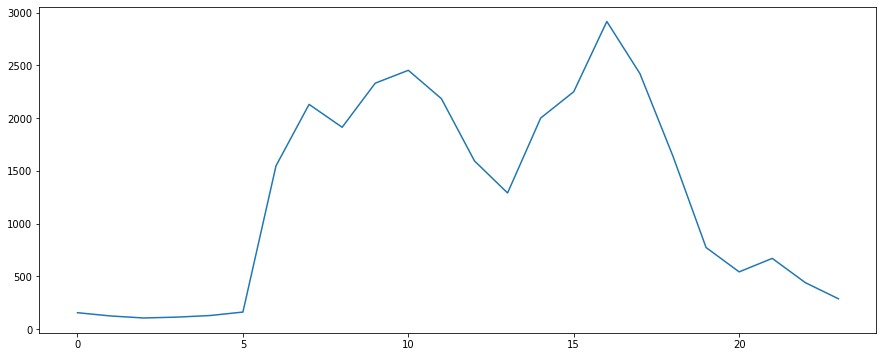

In [17]:
plt.figure(figsize=(15,6))
plt.plot(songs_per_hour.index, songs_per_hour["total_songs"])
plt.show()

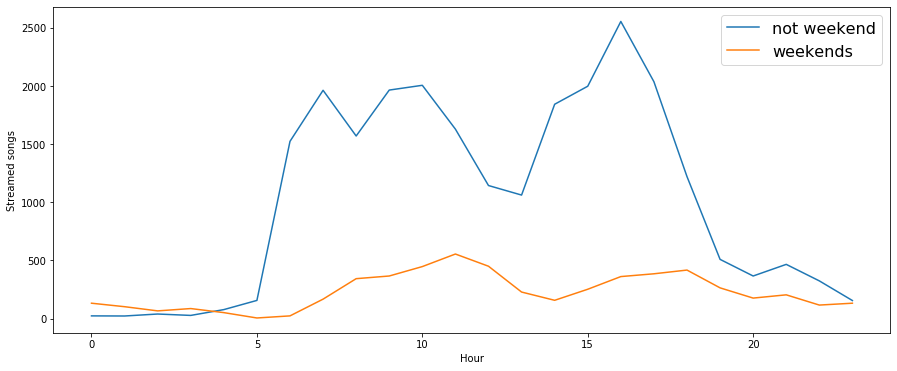

In [19]:
# weekdays vs weekends
songs_not_weekend = (
    df_history
    .query("weekend == 0")
    .groupby("hour")
    .count()
    [["endTime"]]
    .rename(columns={"endTime": "total_songs"})
)

songs_weekends = (
    df_history
    .query("weekend == 1")
    .groupby("hour")
    .count()
    [["endTime"]]
    .rename(columns={"endTime": "total_songs"})
)

plt.figure(figsize=(15,6))
plt.plot(songs_not_weekend.index,
         songs_not_weekend["total_songs"], 
         label="not weekend")  # labels are custom
plt.plot(songs_weekends.index, 
         songs_weekends["total_songs"], 
         label="weekends")
plt.legend(fontsize=16)
plt.xlabel("Hour")
plt.ylabel("Streamed songs")
plt.show()

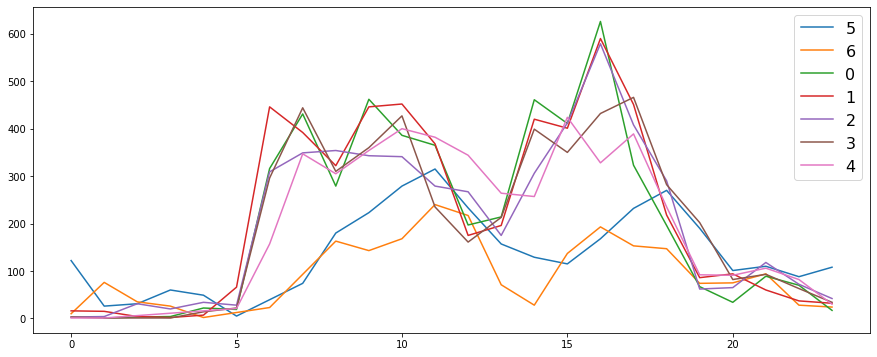

In [21]:
# per hour and per day of the week
# 0 Monday, 1 Tuesday, ..., 6 Sunday
plt.figure(figsize=(15,6))

for wkday in df_history["weekday"].unique():
    songs_weekday = (
        df_history
        .query("weekday == @wkday")
        .groupby("hour")
        .count()
        [["endTime"]]
        .rename(columns={"endTime": "total_songs"})  
    )
    
    plt.plot(songs_weekday.index,
             songs_weekday["total_songs"],
             label=wkday)

plt.legend(fontsize=16)
plt.show()

In [22]:
# convert hour to category: night, morning, afternoon, evening
# pd.cut will convert a numeric variable into a categorical

df_history["day_period"] = pd.cut(
    df_history["hour"], 
    bins=[0, 6, 14, 18, 24],
    include_lowest=True,
    labels=["night", "morning", "afternoon", "evening"]
)

df_history# .query("hour ==0")

,endTime,artistName,trackName,msPlayed,sec_played,sec_played_td,start_time,year,month,year_month,day,hour,weekday,weekend,day_period
0,2018-12-29 13:29:00,Jeff Buckley,Everybody Here Wants You,195299,195,00:03:15,2018-12-29 13:25:45,2018,12,2018_12,29,13,5,1,morning
1,2018-12-29 13:33:00,Future Islands,Time On Her Side,218506,219,00:03:39,2018-12-29 13:29:21,2018,12,2018_12,29,13,5,1,morning
2,2018-12-29 13:35:00,The Whitest Boy Alive,Burning,144044,144,00:02:24,2018-12-29 13:32:36,2018,12,2018_12,29,13,5,1,morning
3,2018-12-29 13:36:00,The Whitest Boy Alive,Burning,47144,47,00:00:47,2018-12-29 13:35:13,2018,12,2018_12,29,13,5,1,morning
4,2018-12-29 13:41:00,Cut Copy,Take Me Over,248289,248,00:04:08,2018-12-29 13:36:52,2018,12,2018_12,29,13,5,1,morning
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30161,2019-12-29 12:47:00,El Palacio de Linares,Ciervo y Erizo,149266,149,00:02:29,2019-12-29 12:44:31,2019,12,2019_12,29,12,6,1,morning
30162,2019-12-29 12:48:00,Los Chikos del Maiz,Grupo Salvaje,19772,20,00:00:20,2019-12-29 12:47:40,2019,12,2019_12,29,12,6,1,morning
30163,2019-12-29 13:00:00,Los Chikos del Maiz,Grupo Salvaje,169087,169,00:02:49,2019-12-29 12:57:11,2019,12,2019_12,29,12,6,1,morning
30164,2019-12-29 13:03:00,John Grant,GMF,181394,181,00:03:01,2019-12-29 12:59:59,2019,12,2019_12,29,12,6,1,morning


In [23]:
# which period has more listening activity
df_history.groupby("day_period").count()["endTime"]

day_period
night         2333
morning      15895
afternoon     9226
evening       2712
Name: endTime, dtype: int64

### Evolution of played songs during the year

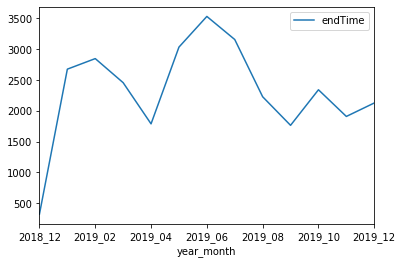

In [24]:
df_history.groupby("year_month").count()[["endTime"]].plot()

### Acummulated time listening to music

In [25]:
df_history["accum_play_time"] = df_history["sec_played"].cumsum()  # cummulative sum

df_history.tail()

,endTime,artistName,trackName,msPlayed,sec_played,sec_played_td,start_time,year,month,year_month,day,hour,weekday,weekend,day_period,accum_play_time
30161,2019-12-29 12:47:00,El Palacio de Linares,Ciervo y Erizo,149266,149,00:02:29,2019-12-29 12:44:31,2019,12,2019_12,29,12,6,1,morning,4466891
30162,2019-12-29 12:48:00,Los Chikos del Maiz,Grupo Salvaje,19772,20,00:00:20,2019-12-29 12:47:40,2019,12,2019_12,29,12,6,1,morning,4466911
30163,2019-12-29 13:00:00,Los Chikos del Maiz,Grupo Salvaje,169087,169,00:02:49,2019-12-29 12:57:11,2019,12,2019_12,29,12,6,1,morning,4467080
30164,2019-12-29 13:03:00,John Grant,GMF,181394,181,00:03:01,2019-12-29 12:59:59,2019,12,2019_12,29,12,6,1,morning,4467261
30165,2019-12-29 13:05:00,Cecilio G.,Million Dollar Baby,119048,119,00:01:59,2019-12-29 13:03:01,2019,12,2019_12,29,13,6,1,morning,4467380


In [26]:
# calculate total time listening to music by getting the maximum value
# in the accum_play_time
total_time = df_history["accum_play_time"].max()

total_time

4467380

In [27]:
# pass seconds to hours and minutes
total_time = df_history.tail(1)["accum_play_time"].values[0]

total_hours = total_time // 3600
total_minutes = (total_time - total_hours * 3600) // 60

print(f"total time: {total_hours} hours and {total_minutes} minutes")

print("total time: {0} hours and {1} minutes"
      .format(total_hours, total_minutes))

total time: 1240 hours and 56 minutes
total time: 1240 hours and 56 minutes


In [28]:
# how many songs I've listened for less t

len(df_history[df_history["sec_played"]<=1])

1085

### Distribution of my listening time

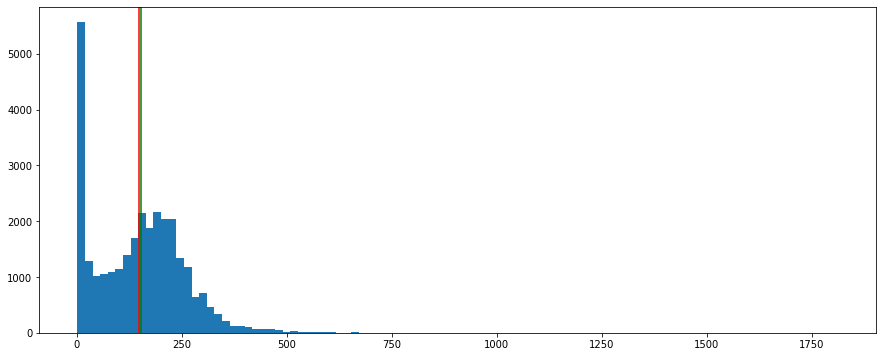

In [44]:
mean_listening_time = df_history["sec_played"].mean()
median_listening_time = df_history["sec_played"].median()

plt.figure(figsize=(15, 6))
plt.hist(df_history["sec_played"], bins=100)
plt.axvline(mean_listening_time, c="red")
plt.axvline(median_listening_time, c="green")
plt.show()

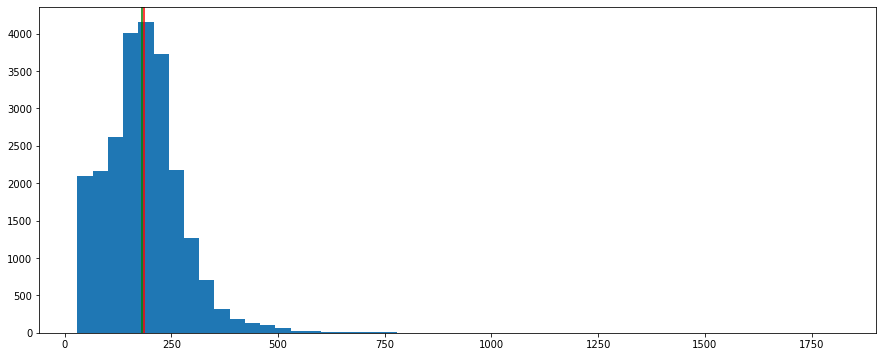

In [49]:
# let's filter those songs that I listen for less than 30 s
listened_m30s = df_history.query("sec_played >= 30")
mean_listening_time_m30 = listened_m30s["sec_played"].mean()
median_listening_time_m30 = listened_m30s["sec_played"].median()

plt.figure(figsize=(15, 6))
plt.hist(listened_m30s["sec_played"], bins=50)
plt.axvline(mean_listening_time_m30, c="red")
plt.axvline(median_listening_time_m30, c="green")
plt.show()